<a href="https://colab.research.google.com/github/jmorenohj/Grupo-5-Fairness-in-Crime/blob/main/Modelo_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shallow network para la prediccion de crimenes en chicago.
Miembros:

David Fernando Adames Rondon

Diego Alejandro Hernandez Castañeda

Jose Luis Moreno Hernandez

A continuacion se muestra el codigo de entrenamiento del modelo utilizado para la entrega 1 del proyecto de la asignatura  "Redes neuronales".

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/Crimes_-_2001_to_Present.csv'
try:
    data = pd.read_csv(file_path)
    data = data[['Date','Year','Latitude','Longitude','Primary Type']]
    data = data[data['Year'] >= 2024]
    data = data[data['Primary Type'].isin(['THEFT', 'BATTERY', 'CRIMINAL DAMAGE'])]
    data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y %I:%M:%S %p')
    data['Month'] = data['Date'].dt.month
    data = data[data['Month'].isin([11, 12])].copy()
    data = data.sort_values('Date')
    data = data.drop('Month', axis=1)
    print(data)
except Exception as e:
    print(f"Error cargando el archivo: {e}")

             Date  Year   Latitude  Longitude     Primary Type
311178 2024-11-01  2024  41.869830 -87.723541          BATTERY
316069 2024-11-01  2024  41.948131 -87.649511          BATTERY
316088 2024-11-01  2024  41.856218 -87.627167  CRIMINAL DAMAGE
336965 2024-11-01  2024  41.750369 -87.610056            THEFT
311948 2024-11-01  2024  41.853684 -87.623836            THEFT
...           ...   ...        ...        ...              ...
349890 2024-12-21  2024  41.876501 -87.642491          BATTERY
349732 2024-12-21  2024  41.722334 -87.660273            THEFT
349513 2024-12-21  2024  41.767413 -87.581258          BATTERY
349849 2024-12-21  2024  41.724256 -87.638435          BATTERY
349508 2024-12-21  2024  41.803182 -87.585432            THEFT

[16752 rows x 5 columns]


In [ ]:
import pandas as pd
from datetime import datetime, timedelta

def create_sliding_windows(df, window_size=28, overlap_days=7):
    """
    Create sliding window dataframes from a datetime-indexed dataframe.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with a 'Date' column
    window_size : int, default=28
        Size of each window in days (4 weeks = 28 days)
    overlap_days : int, default=7
        Number of days to overlap between windows (1 week = 7 days)

    Returns:
    --------
    list of pandas.DataFrame
        List of dataframes, each containing data for a sliding window period
    """
    # Convert Date column to datetime if it's not already
    df['Date'] = pd.to_datetime(df['Date'])

    # Sort dataframe by date
    df = df.sort_values('Date')

    # Get start and end dates
    start_date = df['Date'].min()
    end_date = df['Date'].max()

    # Create list to store window dataframes
    window_dfs = []

    # Create sliding windows
    current_start = start_date
    while current_start + timedelta(days=window_size) <= end_date:
        window_end = current_start + timedelta(days=window_size)

        # Create mask for current window
        mask = (df['Date'] >= current_start) & (df['Date'] < window_end)
        window_df = df[mask].copy()

        # Add window information
        window_df['window_start'] = current_start
        window_df['window_end'] = window_end

        # Store window dataframe
        window_dfs.append(window_df)

        # Move to next window start
        current_start += timedelta(days=overlap_days)

    return window_dfs

def print_window_summary(window_dfs):
    """
    Print a summary of each window's date range and number of records.
    """
    for i, df in enumerate(window_dfs):
        start = df['window_start'].iloc[0].strftime('%Y-%m-%d')
        end = df['window_end'].iloc[0].strftime('%Y-%m-%d')
        print(f"Window {i+1}: {start} to {end} ({len(df)} records)")
def print_window_individual(df):
    start = df['window_start'].iloc[0].strftime('%Y-%m-%d')
    end = df['window_end'].iloc[0].strftime('%Y-%m-%d')
    print(f"Window: {start} to {end} ({len(df)} records)")

In [ ]:
# Create the sliding windows
databyweeks = create_sliding_windows(data)

# Print summary of all windows
print_window_summary(databyweeks)


Window 1: 2024-11-01 to 2024-11-29 (9613 records)
Window 2: 2024-11-08 to 2024-12-06 (9380 records)
Window 3: 2024-11-15 to 2024-12-13 (9266 records)
Window 4: 2024-11-22 to 2024-12-20 (9140 records)


In [ ]:
databyweeks[0]

,Date,Year,Latitude,Longitude,Primary Type,window_start,window_end
311178,2024-11-01 00:00:00,2024,41.869830,-87.723541,BATTERY,2024-11-01,2024-11-29
316736,2024-11-01 00:00:00,2024,41.774329,-87.708606,BATTERY,2024-11-01,2024-11-29
316356,2024-11-01 00:00:00,2024,41.887416,-87.664988,THEFT,2024-11-01,2024-11-29
324791,2024-11-01 00:00:00,2024,41.660104,-87.640117,THEFT,2024-11-01,2024-11-29
315448,2024-11-01 00:00:00,2024,41.951186,-87.650563,BATTERY,2024-11-01,2024-11-29
...,...,...,...,...,...,...,...
336649,2024-11-28 23:00:00,2024,41.918576,-87.773096,BATTERY,2024-11-01,2024-11-29
338601,2024-11-28 23:20:00,2024,41.973057,-87.686982,BATTERY,2024-11-01,2024-11-29
335956,2024-11-28 23:45:00,2024,41.777224,-87.758009,CRIMINAL DAMAGE,2024-11-01,2024-11-29
337089,2024-11-28 23:48:00,2024,41.895423,-87.758062,BATTERY,2024-11-01,2024-11-29


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential

# Generar funciones auxiliares para la capa RBF
class RBFLayer(Dense):
    def __init__(self, units, gamma, **kwargs):
        super().__init__(units, activation=None, **kwargs)
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(
            name='centers',
            shape=(self.units, input_shape[-1]),
            initializer='uniform',
            trainable=True
        )
        super().build(input_shape)

    def call(self, inputs):
        C = K.expand_dims(self.centers, axis=0)
        X = K.expand_dims(inputs, axis=1)
        return K.exp(-self.gamma * K.sum(K.square(C - X), axis=-1))

    def get_config(self):
        config = super().get_config()
        config.update({
            'gamma': self.gamma
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
def train(data,firsttime, tdnn_model):
    # Create a copy of the data to avoid SettingWithCopyWarning
    global scaler
    global le
    data = data.copy()

    # Preprocessing
    data['timestamp'] = pd.to_datetime(data['Date'])
    data['day_of_week'] = data['timestamp'].dt.dayofweek
    data['hour'] = data['timestamp'].dt.hour

    # Clean and handle missing values
    data = data.dropna()

    # Convert coordinates to numbers using loc
    data.loc[:, 'Latitude'] = data['Latitude'].astype(float)
    data.loc[:, 'Longitude'] = data['Longitude'].astype(float)

    # Use LabelEncoder for target variable
    le = LabelEncoder()
    y = le.fit_transform(data['Primary Type'])

    # Feature selection
    features = ['Latitude', 'Longitude', 'day_of_week', 'hour']
    X = data[features].values

    # Normalize features
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    # Add small epsilon to avoid zero values
    epsilon = 1e-7
    X = np.clip(X, epsilon, 1-epsilon)

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Get number of classes
    n_classes = len(np.unique(y))

    if firsttime == True:
      from tensorflow.keras.layers import Input
      # Define input layer explicitly
      inputs = Input(shape=(X_train.shape[1],))
      # Build model using Sequential with explicit input
      tdnn_model = Sequential([
          inputs,
          Dense(32, activation='relu'),
          RBFLayer(10, gamma=0.1),
          Dense(n_classes, activation='softmax')
      ])

    # Compilation with proper loss function
      tdnn_model.compile(
          optimizer=Adam(learning_rate=0.001),
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy']
      )

      # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Training
    history = tdnn_model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=1
    )
    # Evaluation
    loss, accuracy = tdnn_model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {accuracy:.2f}")
    # Plot learning curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return tdnn_model


In [ ]:
databyweeks[0]

,Date,Year,Latitude,Longitude,Primary Type,window_start,window_end
311178,2024-11-01 00:00:00,2024,41.869830,-87.723541,BATTERY,2024-11-01,2024-11-29
316736,2024-11-01 00:00:00,2024,41.774329,-87.708606,BATTERY,2024-11-01,2024-11-29
316356,2024-11-01 00:00:00,2024,41.887416,-87.664988,THEFT,2024-11-01,2024-11-29
324791,2024-11-01 00:00:00,2024,41.660104,-87.640117,THEFT,2024-11-01,2024-11-29
315448,2024-11-01 00:00:00,2024,41.951186,-87.650563,BATTERY,2024-11-01,2024-11-29
...,...,...,...,...,...,...,...
336649,2024-11-28 23:00:00,2024,41.918576,-87.773096,BATTERY,2024-11-01,2024-11-29
338601,2024-11-28 23:20:00,2024,41.973057,-87.686982,BATTERY,2024-11-01,2024-11-29
335956,2024-11-28 23:45:00,2024,41.777224,-87.758009,CRIMINAL DAMAGE,2024-11-01,2024-11-29
337089,2024-11-28 23:48:00,2024,41.895423,-87.758062,BATTERY,2024-11-01,2024-11-29


# Cargamos los datos del centroide y creamos la funcion que predice

In [ ]:
weekinference_crude = pd.read_pickle('centroides.pkl')

In [ ]:
import numpy as np
import pandas as pd

def predict_crime_probabilities(model, scaler, label_encoder, df, day_of_week=0):
    """
    Predice las probabilidades de crimen para cada ubicación en el dataframe.

    Parámetros:
    model: Modelo entrenado
    scaler: Scaler ajustado
    label_encoder: LabelEncoder ajustado
    df: DataFrame con columnas 'latitud' y 'Longitud'
    day_of_week: Día de la semana para la predicción (default:0  'Monday')

    Retorna:
    DataFrame con las coordenadas originales, probabilidades de los 3 crímenes más probables
    y el día de la semana
    """
    # Crear DataFrame de características
    X = df.copy()

    # Agregar columna de día de la semana
    X['day_of_week'] = day_of_week

    # Agregar columna de hora (medianoche como valor predeterminado)
    X['hour'] = 0

    # Preparar características en el orden correcto
    features = ['Latitude', 'Longitude', 'day_of_week', 'hour']
    X_sample = X[features].values

    # Escalar características
    X_scaled = scaler.transform(X_sample)

    # Obtener predicciones
    predictions = model.predict(X_scaled)

    # Crear DataFrame de resultado
    results = pd.DataFrame()
    results['Latitude'] = df['Latitude']
    results['Longitude'] = df['Longitude']
    results['day_of_week'] = day_of_week

    # Obtener índices de las clases específicas
    theft_idx = np.where(label_encoder.classes_ == 'THEFT')[0][0]
    battery_idx = np.where(label_encoder.classes_ == 'BATTERY')[0][0]
    criminal_damage_idx = np.where(label_encoder.classes_ == 'CRIMINAL DAMAGE')[0][0]

    # Agregar probabilidades para cada tipo de crimen específico
    for i in range(len(predictions)):
        results.loc[i, 'THEFT probability'] = predictions[i][theft_idx]  # THEFT
        results.loc[i, 'BATTERY probability'] = predictions[i][battery_idx]  # BATTERY
        results.loc[i, 'CRIMINAL DAMAGE probability'] = predictions[i][criminal_damage_idx]  # CRIMINAL DAMAGE

    return results

### El main

Window: 2024-11-01 to 2024-11-29 (9613 records)
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.2608 - loss: 1.3470 - val_accuracy: 0.4443 - val_loss: 1.0603
Epoch 2/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4493 - loss: 1.0563 - val_accuracy: 0.4443 - val_loss: 1.0595
Epoch 3/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4373 - loss: 1.0581 - val_accuracy: 0.4443 - val_loss: 1.0594
Epoch 4/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4482 - loss: 1.0571 - val_accuracy: 0.4443 - val_loss: 1.0572
Epoch 5/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4473 - loss: 1.0526 - val_accuracy: 0.4443 - val_loss: 1.0541
Epoch 6/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4387 - loss: 1.0540 - val_accuracy: 0.4443 - val_loss: 1.0547
Epoch 7/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4341 - loss: 1.0539 - val_accuracy: 0.4428 - val_loss: 1.0502
Epoch 8/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4426 - loss: 1.0502 - val_accuracy: 0.4459 - val

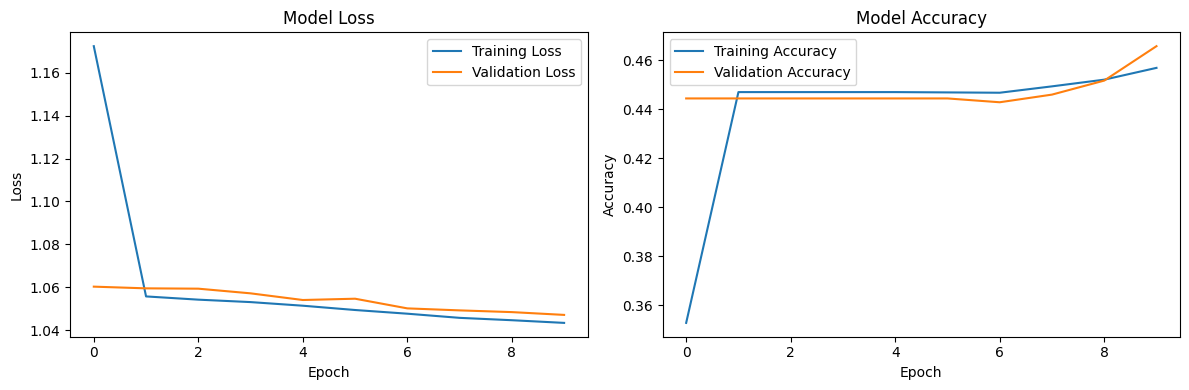

Obteniendo los valores del modelo para la semana:  5
Prediciendo el valor del dia: 0
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Prediciendo el valor del dia: 1
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Prediciendo el valor del dia: 2
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Prediciendo el valor del dia: 3
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Prediciendo el valor del dia: 4
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Prediciendo el valor del dia: 5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Prediciendo el valor del dia: 6
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Window: 2024-11-08 to 2024-12-06 (9380 records)
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4677 - loss: 1.0348 - val_accuracy: 0.4731 - val_loss: 1.0406
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4743 - loss: 1.0306 - val_accuracy: 0.4715 - val_loss: 1.0377
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4658 - loss: 1.0384 - val_accuracy: 0.4715 - val_loss: 1.0376
Epoch 4/10

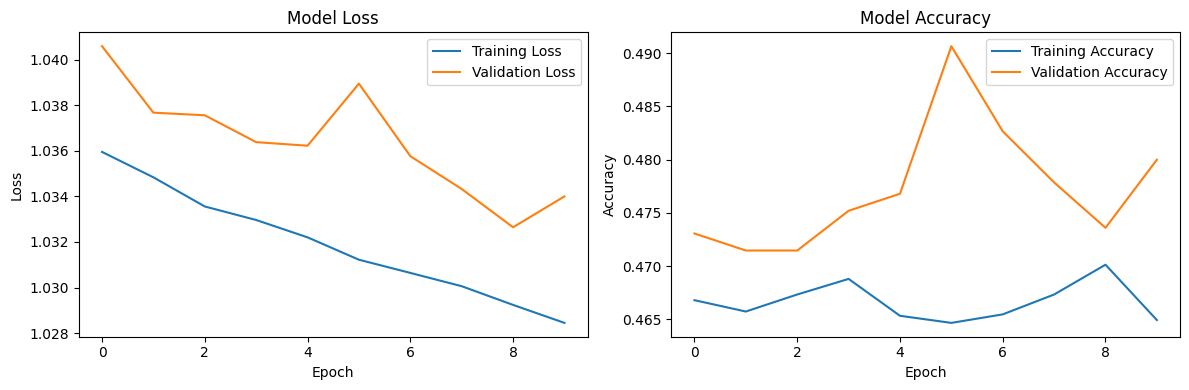

Obteniendo los valores del modelo para la semana:  6
Prediciendo el valor del dia: 0
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Prediciendo el valor del dia: 1
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Prediciendo el valor del dia: 2
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Prediciendo el valor del dia: 3
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Prediciendo el valor del dia: 4
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Prediciendo el valor del dia: 5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Prediciendo el valor del dia: 6
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Window: 2024-11-15 to 2024-12-13 (9266 records)
Epoch 1/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4718 - loss: 1.0235 - val_accuracy: 0.4665 - val_loss: 1.0445
Epoch 2/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4718 - loss: 1.0269 - val_accuracy: 0.4617 - val_loss: 1.0470
Epoch 3/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4558 - loss: 1.0322 - val_accuracy: 0.4633 - val_loss: 1.0444
Epoch 4/10


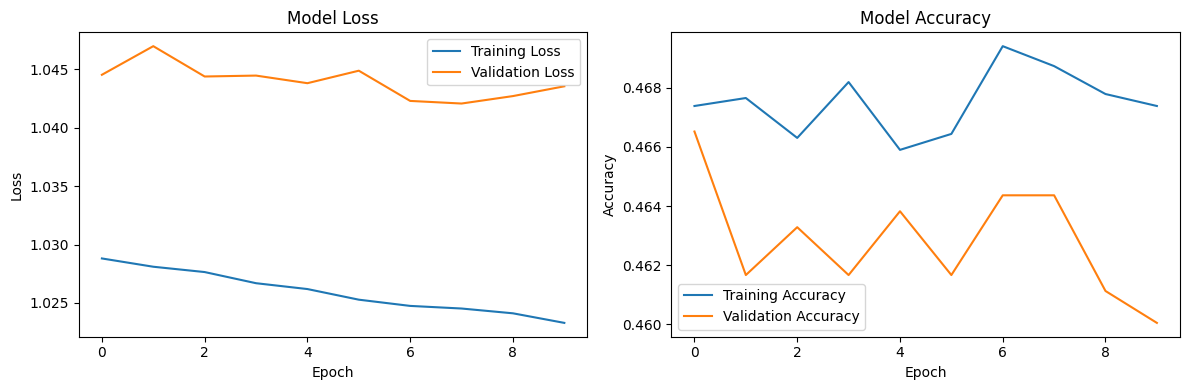

Obteniendo los valores del modelo para la semana:  7
Prediciendo el valor del dia: 0
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Prediciendo el valor del dia: 1
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Prediciendo el valor del dia: 2
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Prediciendo el valor del dia: 3
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Prediciendo el valor del dia: 4
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Prediciendo el valor del dia: 5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Prediciendo el valor del dia: 6
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Window: 2024-11-22 to 2024-12-20 (9140 records)
Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4642 - loss: 1.0287 - val_accuracy: 0.4548 - val_loss: 1.0282
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4687 - loss: 1.0209 - val_accuracy: 0.4542 - val_loss: 1.0277
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4634 - loss: 1.0295 - val_accuracy: 0.4542 - val_loss: 1.0280
Epoch 4/10


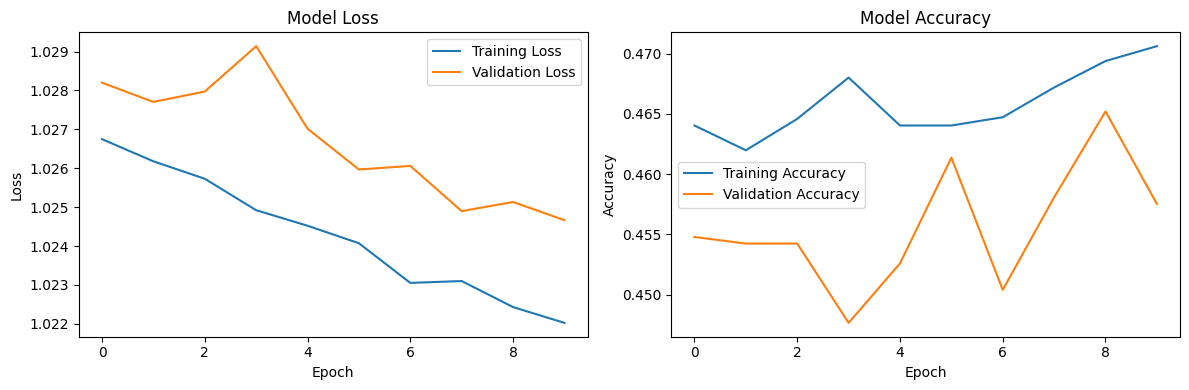

Obteniendo los valores del modelo para la semana:  8
Prediciendo el valor del dia: 0
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Prediciendo el valor del dia: 1
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Prediciendo el valor del dia: 2
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Prediciendo el valor del dia: 3
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Prediciendo el valor del dia: 4
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Prediciendo el valor del dia: 5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Prediciendo el valor del dia: 6
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
firsttime = True
resultweek = []
all_inference_weeks = []
contador_semana = 5
for data in databyweeks:
  print_window_individual(data)
  if firsttime==True:
    tdnn_model = train(data,firsttime,0)
    firsttime = False
  else:
    train(data,firsttime,tdnn_model)
  print("Obteniendo los valores del modelo para la semana: ", contador_semana)
  resultweek = []
  for day in range(0,7):
    print("Prediciendo el valor del dia:", day)
    weekinference = predict_crime_probabilities(tdnn_model,scaler,le, weekinference_crude,day)
    #Agregamos el dia a un dataset
    resultweek.append(weekinference)
  # Combinamos todos los dias para obtener un dataframe de una semana completa
  contador_semana+=1
  week = pd.concat(resultweek, ignore_index=True)
  #Lo agregamos al dataframe principal que contendra las 4 semanas predecidas
  all_inference_weeks.append(week)


# Semana 5 obtenida a partir del modelo (29-11-2024 a 06-12-2024)

In [ ]:
d1 = all_inference_weeks[0]
d1.to_pickle('semana5.pkl')
d1

,Latitude,Longitude,day_of_week,THEFT probability,BATTERY probability,CRIMINAL DAMAGE probability
0,41.649054,-87.612140,0,0.311311,0.384887,0.303802
1,41.648978,-87.600136,0,0.313669,0.385756,0.300575
2,41.648901,-87.588133,0,0.316012,0.386567,0.297421
3,41.648823,-87.576129,0,0.318338,0.387322,0.294340
4,41.648743,-87.564126,0,0.320646,0.388019,0.291336
...,...,...,...,...,...,...
4202,42.009533,-87.668442,6,0.416909,0.348559,0.234532
4203,42.018740,-87.704567,6,0.417198,0.345615,0.237187
4204,42.018673,-87.692494,6,0.418462,0.346135,0.235403
4205,42.018605,-87.680421,6,0.419698,0.346642,0.233661


# Semana 6 obtenida a partir del modelo (06-12-2024 a 13-12-2024)

In [ ]:
d2 = all_inference_weeks[1]
d2.to_pickle('semana6.pkl')
d2

,Latitude,Longitude,day_of_week,THEFT probability,BATTERY probability,CRIMINAL DAMAGE probability
0,41.649054,-87.612140,0,0.259193,0.376975,0.363832
1,41.648978,-87.600136,0,0.264033,0.376934,0.359033
2,41.648901,-87.588133,0,0.268883,0.376815,0.354301
3,41.648823,-87.576129,0,0.273735,0.376622,0.349642
4,41.648743,-87.564126,0,0.278583,0.376357,0.345060
...,...,...,...,...,...,...
4202,42.009533,-87.668442,6,0.440467,0.323734,0.235799
4203,42.018740,-87.704567,6,0.435997,0.325019,0.238984
4204,42.018673,-87.692494,6,0.440012,0.323716,0.236273
4205,42.018605,-87.680421,6,0.443954,0.322414,0.233631


# Semana 7 obtenida a partir del modelo (13-12-2024 a 20-12-2024)

In [ ]:
d3 = all_inference_weeks[2]
d3.to_pickle('semana7.pkl')
d3

,Latitude,Longitude,day_of_week,THEFT probability,BATTERY probability,CRIMINAL DAMAGE probability
0,41.649054,-87.612140,0,0.213258,0.382130,0.404612
1,41.648978,-87.600136,0,0.220236,0.381441,0.398322
2,41.648901,-87.588133,0,0.227301,0.380631,0.392067
3,41.648823,-87.576129,0,0.234438,0.379705,0.385857
4,41.648743,-87.564126,0,0.241630,0.378667,0.379704
...,...,...,...,...,...,...
4202,42.009533,-87.668442,6,0.463437,0.321626,0.214937
4203,42.018740,-87.704567,6,0.452498,0.327042,0.220460
4204,42.018673,-87.692494,6,0.459021,0.324104,0.216875
4205,42.018605,-87.680421,6,0.465833,0.321034,0.213134


# Semana 8 obtenida a partir del modelo (20-12-2024 a 27-12-2024)

In [ ]:
d3 = all_inference_weeks[3]
d3.to_pickle('semana8.pkl')
d3

,Latitude,Longitude,day_of_week,THEFT probability,BATTERY probability,CRIMINAL DAMAGE probability
0,41.649054,-87.612140,0,0.222704,0.409833,0.367463
1,41.648978,-87.600136,0,0.232055,0.406194,0.361751
2,41.648901,-87.588133,0,0.241479,0.402473,0.356048
3,41.648823,-87.576129,0,0.250863,0.398777,0.350359
4,41.648743,-87.564126,0,0.260291,0.394992,0.344717
...,...,...,...,...,...,...
4202,42.009533,-87.668442,6,0.470718,0.319567,0.209715
4203,42.018740,-87.704567,6,0.459335,0.327770,0.212895
4204,42.018673,-87.692494,6,0.465426,0.323971,0.210602
4205,42.018605,-87.680421,6,0.472440,0.319571,0.207989
